#### 라이브러리 불러오기 & 데이터 불러오기

In [131]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import cross_val_score,GridSearchCV
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import Ridge,Lasso
from sklearn.tree import DecisionTreeRegressor
%matplotlib inline

train=pd.read_csv('/content/drive/MyDrive/따릉이/train.csv')
test=pd.read_csv('/content/drive/MyDrive/따릉이/test.csv')

In [132]:
train.head(10)

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
0,3,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0
1,6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0
2,7,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0
3,8,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0,57.0
4,9,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0
5,13,2,13.6,0.0,1.7,80.0,1073.0,0.027,34.0,15.0,39.0
6,14,3,10.6,0.0,1.5,58.0,1548.0,0.038,62.0,33.0,23.0
7,16,21,16.0,0.0,6.0,21.0,1961.0,0.050,90.0,28.0,146.0
8,19,9,13.8,0.0,1.9,64.0,1344.0,0.039,93.0,19.0,39.0
9,20,14,17.2,0.0,2.1,32.0,1571.0,0.025,64.0,19.0,83.0


In [133]:
train.describe()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
count,1459.000000,1459.000000,1457.000000,1457.000000,1450.000000,1457.000000,1457.000000,1383.000000,1369.000000,1342.000000,1459.000000
mean,1105.914325,11.493489,16.717433,0.031572,2.479034,52.231297,1405.216884,0.039149,57.168736,30.327124,108.563400
std,631.338681,6.922790,5.239150,0.174917,1.378265,20.370387,583.131708,0.019509,31.771019,14.713252,82.631733
min,3.000000,0.000000,3.100000,0.000000,0.000000,7.000000,78.000000,0.003000,9.000000,8.000000,1.000000
25%,555.500000,5.500000,12.800000,0.000000,1.400000,36.000000,879.000000,0.025500,36.000000,20.000000,37.000000
50%,1115.000000,11.000000,16.600000,0.000000,2.300000,51.000000,1577.000000,0.039000,51.000000,26.000000,96.000000
75%,1651.000000,17.500000,20.100000,0.000000,3.400000,69.000000,1994.000000,0.052000,69.000000,37.000000,150.000000
max,2179.000000,23.000000,30.000000,1.000000,8.000000,99.000000,2000.000000,0.125000,269.000000,90.000000,431.000000


* 각 피저들의 histogram

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4f9ae8b310>,
      dtype=object)

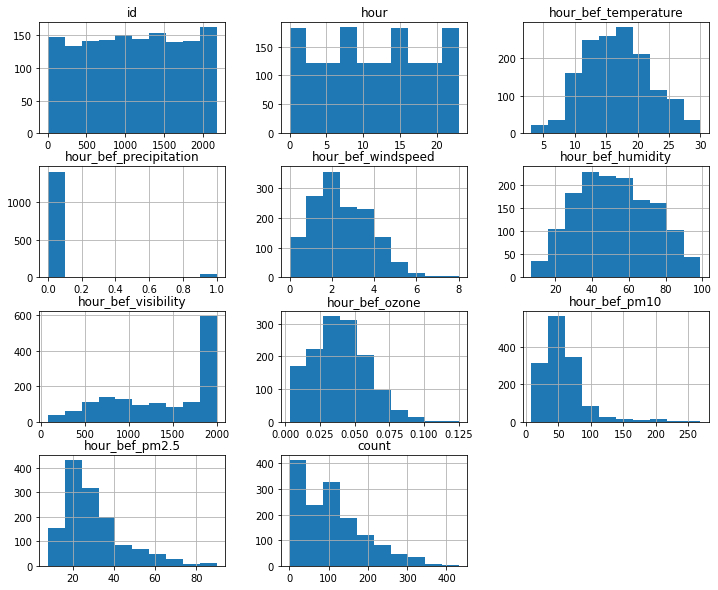

In [134]:
train.hist(figsize=(12,10))

* 시간에 따른 대여 횟수 변화

Text(17, 280, 'work time')

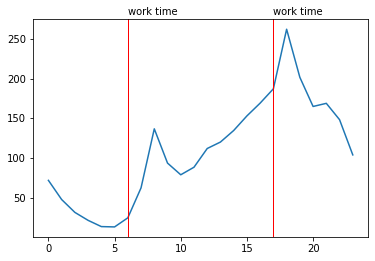

In [135]:
plt.plot(train.groupby('hour')['count'].mean())
plt.axvline(6,color='r',linewidth=1)
plt.axvline(17,color='r',linewidth=1)
plt.text(6,280,'work time')
plt.text(17,280,'work time')

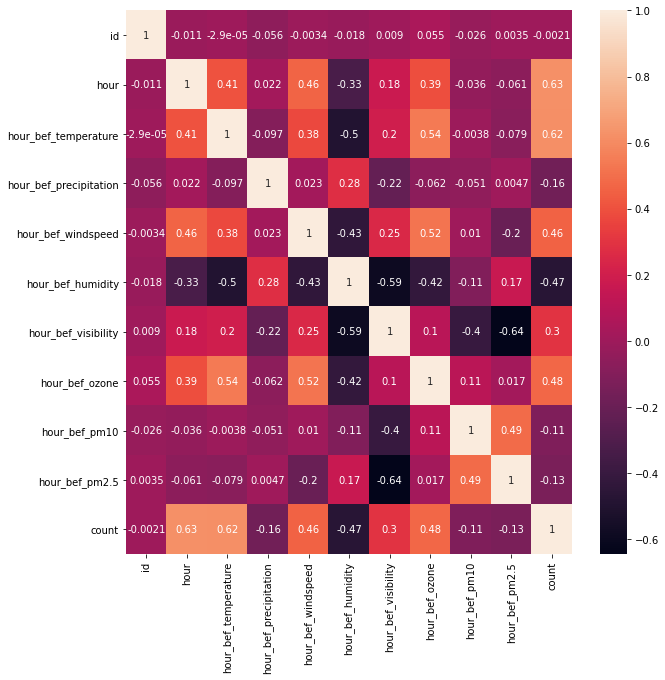

In [136]:
plt.figure(figsize=(10,10))
sns.heatmap(train.corr(),annot=True)

#### 결측치 대체

In [137]:
target=train['count']
train=train.drop('count',axis=1)
imputer = IterativeImputer(missing_values=np.nan, random_state=0, n_nearest_features=5, sample_posterior=True)
train=pd.DataFrame(imputer.fit_transform(train),columns=train.columns)
test=pd.DataFrame(imputer.transform(test),columns=test.columns)
test.isnull().sum() ,train.isnull().sum()

(id                        0
 hour                      0
 hour_bef_temperature      0
 hour_bef_precipitation    0
 hour_bef_windspeed        0
 hour_bef_humidity         0
 hour_bef_visibility       0
 hour_bef_ozone            0
 hour_bef_pm10             0
 hour_bef_pm2.5            0
 dtype: int64, id                        0
 hour                      0
 hour_bef_temperature      0
 hour_bef_precipitation    0
 hour_bef_windspeed        0
 hour_bef_humidity         0
 hour_bef_visibility       0
 hour_bef_ozone            0
 hour_bef_pm10             0
 hour_bef_pm2.5            0
 dtype: int64)

#### feature scaling

In [138]:
columns=[column for column in train.columns if column not in ['hour_bef_precipitation']]
columns

['id',
 'hour',
 'hour_bef_temperature',
 'hour_bef_windspeed',
 'hour_bef_humidity',
 'hour_bef_visibility',
 'hour_bef_ozone',
 'hour_bef_pm10',
 'hour_bef_pm2.5']

In [139]:
train

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
0,3.0,20.0,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0
1,6.0,13.0,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0
2,7.0,6.0,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0
3,8.0,23.0,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0
4,9.0,18.0,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0
...,...,...,...,...,...,...,...,...,...,...
1454,2174.0,4.0,16.8,0.0,1.6,53.0,2000.0,0.031,37.0,27.0
1455,2175.0,3.0,10.8,0.0,3.8,45.0,2000.0,0.039,34.0,19.0
1456,2176.0,5.0,18.3,0.0,1.9,54.0,2000.0,0.009,30.0,21.0
1457,2178.0,21.0,20.7,0.0,3.7,37.0,1395.0,0.082,71.0,36.0


In [140]:
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler()
train=pd.DataFrame(scaler.fit_transform(train),index=train.index,columns=train.columns)
train.describe()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
count,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,0.506854,0.499717,0.506395,0.169265,0.310122,0.491569,0.545301,0.410167,0.310412,0.416123
std,0.290137,0.300991,0.194709,0.150094,0.171962,0.221392,0.239719,0.133432,0.103660,0.145407
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.253906,0.239130,0.360595,0.142168,0.175000,0.315217,0.329003,0.315942,0.242055,0.315849
50%,0.511029,0.478261,0.501859,0.142168,0.287500,0.478261,0.615701,0.404869,0.294102,0.383631
75%,0.757353,0.760870,0.631970,0.142168,0.425000,0.668478,0.786980,0.493797,0.352656,0.491392
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [141]:
test=pd.DataFrame(scaler.transform(test),index=test.index,columns=test.columns)
test.describe()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
count,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000
mean,0.484308,0.498814,0.749309,0.186637,0.298748,0.539974,0.525970,0.425571,0.245108,0.364862
std,0.287488,0.301236,0.150224,0.190152,0.146388,0.213584,0.252307,0.139512,0.046487,0.102432
min,-0.001379,0.000000,0.427509,0.142168,0.000000,0.097826,0.019716,0.165449,0.050794,0.037055
25%,0.231618,0.239130,0.637546,0.142168,0.187500,0.380435,0.298814,0.329623,0.212778,0.286529
50%,0.479320,0.478261,0.736059,0.142168,0.287500,0.521739,0.576270,0.411710,0.238802,0.354944
75%,0.741498,0.739130,0.864312,0.142168,0.412500,0.722826,0.789444,0.500638,0.271331,0.423359
max,0.999081,1.000000,1.141264,1.000000,0.737500,1.010870,0.789444,1.088928,0.469490,0.794755


In [154]:
rf=RandomForestRegressor(n_estimators=600,max_depth=16,max_leaf_nodes=60,random_state=0)
score=cross_val_score(rf,train,target,scoring='neg_mean_squared_error',cv=5)
score.mean()

-1579.2574237292338

In [155]:
rf=RandomForestRegressor(n_estimators=600,max_depth=16,max_leaf_nodes=60,random_state=0)
rf.fit(train,target)
pred=rf.predict(test)

submission=pd.read_csv("/content/drive/MyDrive/따릉이/submission.csv")
submission['count']=pred
#submission.to_csv("/content/drive/MyDrive/따릉이/submission_09.csv",index=False)
submission.head(10)

,id,count
0,0,81.914571
1,1,229.929049
2,2,78.336995
3,4,20.192521
4,5,43.470837
5,10,116.171022
6,11,183.570140
7,12,327.623306
8,15,20.192521
9,17,118.903214


<BarContainer object of 10 artists>

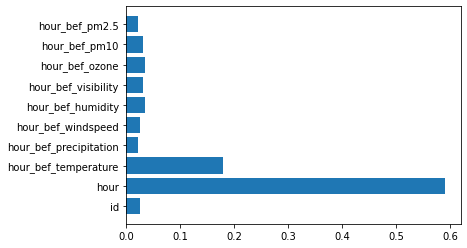

In [144]:
plt.barh(train.columns,rf.feature_importances_)

In [151]:
rf.estimator_params

('criterion',
 'max_depth',
 'min_samples_split',
 'min_samples_leaf',
 'min_weight_fraction_leaf',
 'max_features',
 'max_leaf_nodes',
 'min_impurity_decrease',
 'min_impurity_split',
 'random_state',
 'ccp_alpha')

In [156]:
params={
    'n_estimators':[500,600,800],
    'max_depth':[14,16,20],
    'max_leaf_nodes':[24,30,40,60,80]
}

rf=RandomForestRegressor(random_state=0)
grid=GridSearchCV(rf,param_grid=params,cv=3,scoring='neg_mean_squared_error')
grid.fit(train,target)


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=0,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs=

In [157]:
print(grid.best_params_)
print(grid.best_score_)

{'max_depth': 20, 'max_leaf_nodes': 80, 'n_estimators': 600}
-1685.1013166327575
